In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from new import *

# RG flow

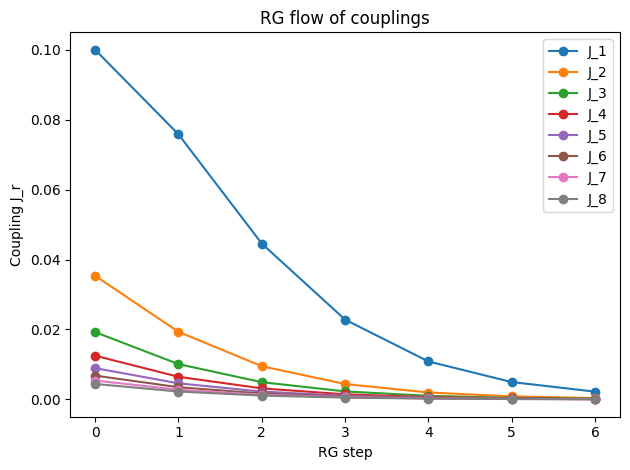


RG step 0:
 [[1.     0.8187]
 [0.8187 1.    ]]

RG step 1:
 [[1.     0.8593]
 [0.8593 1.    ]]

RG step 2:
 [[1.     0.9147]
 [0.9147 1.    ]]

RG step 3:
 [[1.     0.9554]
 [0.9554 1.    ]]

RG step 4:
 [[1.     0.9785]
 [0.9785 1.    ]]

RG step 5:
 [[1.     0.9901]
 [0.9901 1.    ]]

RG step 6:
 [[1.     0.9956]
 [0.9956 1.    ]]


In [10]:
J0 = 1/10
a = 1.5
max_dist_final = 8
n_steps = 6

J_list, T_list = generate_rg_flow(J0, a, max_dist_final, n_steps, trace_TM=True, TM_r=1)
flows = extract_flows(J_list, max_dist_final)
plot_rg_flow(flows, distances_to_plot=[1, 2, 3, 4, 5, 6, 7, 8])

[print(f"\nRG step {i}:\n", np.round(t, 4)) for i, t in enumerate(T_list)];

# Phase determination

In [11]:
J0 = 1
a = 1.5

phase, step = find_phase(
        J0, a,
        TM_r=1,
        max_dist_final=8,
        n_steps=5,
        threshold=0.1
    )
print(f"Phase at J0={J0}, a={a}: {phase} (decided at step {step})")

Phase at J0=1, a=1.5: ferromagnetic (decided at step 1)


# Critical point

In [17]:
Jc = find_Jc(
    a=1.5,
    Jlow=1e-2, Jhigh=1e2,
    max_steps=6, max_dist_final=5,
    tol=1e-5,
    growth_threshold=1e4, decay_threshold=1e-4
)
print("Critical Jc =", Jc)
print("Critical Tc =", 1/Jc)

Critical Jc = 0.41798577338457105
Critical Tc = 2.3924259237405727


## Critical line

a = 0.8000  →  Jc = 0.018, Tc = 55.5
a = 0.9000  →  Jc = 0.0736, Tc = 13.6
a = 1.0000  →  Jc = 0.128, Tc = 7.81


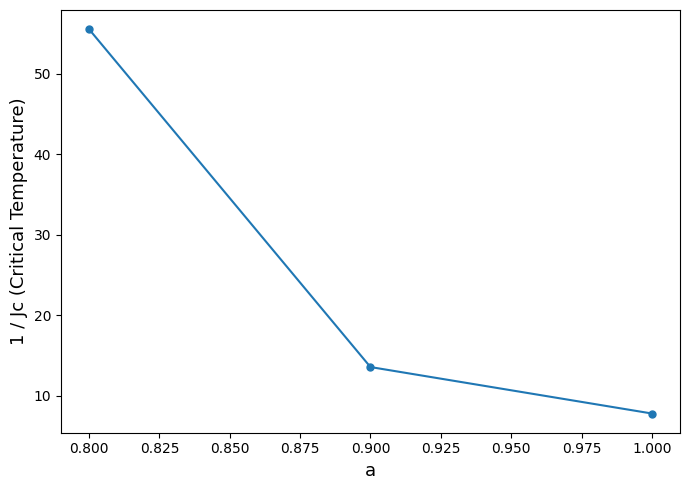

In [18]:
a_vals = np.linspace(.8, 1, 3)
Jc_vals = []
Tc_vals = []

for a in a_vals:
    Jc = find_Jc(
        a=a,
        Jlow=1e-5, Jhigh=1e2,
        max_steps=6, max_dist_final=5,
        tol=1e-5,
        growth_threshold=1e4, decay_threshold=1e-4
    )
    Jc_vals.append(Jc)
    Tc_vals.append(1.0 / Jc)
    print(f"a = {a:.4f}  →  Jc = {Jc:.3}, Tc = {1/Jc:.3}")

Jc_vals = np.array(Jc_vals)
Tc_vals = np.array(Tc_vals)

# ----- plot -----
plt.figure(figsize=(7,5))
plt.plot(a_vals, Tc_vals, 'o-', ms=5)
plt.xlabel("a", fontsize=13)
plt.ylabel("1 / Jc (Critical Temperature)", fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

# Fixed point

In [24]:
a = 1
tolerance = 1e-5

Jc = find_Jc(
    a=a,
    Jlow=1e-2, Jhigh=1e2,
    max_steps=6, max_dist_final=5,
    tol=tolerance,
    growth_threshold=1e4, decay_threshold=1e-4
)
print("Critical J =", Jc)

J0 = build_initial_guess(Jc, a=a, D=200)

J_star, info = newton_rg_lstsq(J0, verbose=True)
print("Fixed point J*:\n", J_star)

Critical J = 0.12799049526453016
[lstsq] iter 0: D=200, D1=66, ||J'-J||=1.960e-02
[lstsq] iter 1: D=200, D1=66, ||J'-J||=1.367e-02
[lstsq] iter 2: D=200, D1=66, ||J'-J||=8.602e-03
[lstsq] iter 3: D=200, D1=66, ||J'-J||=5.268e-03
[lstsq] iter 4: D=200, D1=66, ||J'-J||=1.874e-03
[lstsq] iter 5: D=200, D1=66, ||J'-J||=3.904e-04
[lstsq] iter 6: D=200, D1=66, ||J'-J||=1.304e-04
[lstsq] iter 7: D=200, D1=66, ||J'-J||=5.472e-05
[lstsq] iter 8: D=200, D1=66, ||J'-J||=2.147e-05
[lstsq] iter 9: D=200, D1=66, ||J'-J||=7.297e-06
Fixed point J*:
 [0.         0.12242913 0.05533485 0.03232251 0.02482908 0.022188
 0.02103317 0.01699398 0.01350825 0.01072418 0.00987416 0.00938945
 0.0089723  0.00849432 0.00820056 0.00792457 0.00782142 0.00787141
 0.00788337 0.0072592  0.00662165 0.00606923 0.00566228 0.00525101
 0.00488706 0.00450457 0.00409968 0.0037425  0.00367203 0.00363021
 0.00357539 0.00350288 0.00344999 0.00338925 0.00333532 0.00329874
 0.00325412 0.00318257 0.00312    0.00305597 0.00302074 0.00

In [27]:
err = check_fixed_point(J_star, tol=tolerance)

Fixed-point error norm = 2.456e-06
✔ Fixed point verified.


# Thermal exponent yT

In [17]:
eigvals = np.linalg.eigvals(T)
sorted(eigvals, key=lambda z: abs(z), reverse=True)

[np.complex128(0.9903752227215321+0j),
 np.complex128(0.07850922163759894+0.5638916862327947j),
 np.complex128(0.07850922163759894-0.5638916862327947j),
 np.complex128(-0.3338885447679921+0.14808709638844178j),
 np.complex128(-0.3338885447679921-0.14808709638844178j),
 np.complex128(-0.0465092240634397+0.04969023384763349j),
 np.complex128(-0.0465092240634397-0.04969023384763349j),
 np.complex128(0.04567000259008869+0.04698151187428088j),
 np.complex128(0.04567000259008869-0.04698151187428088j),
 np.complex128(8.082994499086263e-07+1.0831665608747473e-06j),
 np.complex128(8.082994499086263e-07-1.0831665608747473e-06j),
 np.complex128(-1.3421954994200436e-06+1.584209343460691e-07j),
 np.complex128(-1.3421954994200436e-06-1.584209343460691e-07j),
 np.complex128(5.338960494510038e-07+1.2415874953831748e-06j),
 np.complex128(5.338960494510038e-07-1.2415874953831748e-06j),
 np.complex128(-4.185951273997834e-07+7.250294097923484e-07j),
 np.complex128(-4.185951273997834e-07-7.250294097923484e

In [19]:
eigvals = np.linalg.eigvals(T)
sorted(eigvals, key=lambda z: abs(z), reverse=True)

[np.complex128(1.175722998750728+0j),
 np.complex128(-0.033972251174757204+0.551739105132672j),
 np.complex128(-0.033972251174757204-0.551739105132672j),
 np.complex128(-0.4321225208187315+0j),
 np.complex128(-0.05828538794713179+0j),
 np.complex128(-0.0005054380390428098+0.052298058460556435j),
 np.complex128(-0.0005054380390428098-0.052298058460556435j),
 np.complex128(0.03975017575197801+0j),
 np.complex128(-4.406123704883938e-09+0j),
 np.complex128(4.4061236495461835e-09+0j),
 np.complex128(3.810853620406423e-17+3.229102878918244e-09j),
 np.complex128(3.810853620406423e-17-3.229102878918244e-09j),
 np.complex128(1.1138558467338327e-09+1.3911447526262173e-09j),
 np.complex128(1.1138558467338327e-09-1.3911447526262173e-09j),
 np.complex128(-1.1138558893930664e-09+1.3911446682450236e-09j),
 np.complex128(-1.1138558893930664e-09-1.3911446682450236e-09j),
 np.complex128(1.7497666423054928e-09+0j),
 np.complex128(-1.749766534506616e-09+0j),
 np.complex128(-2.714907045652127e-18+6.4221332

In [22]:
a = 2
N = 100

Jc = find_Jc(
    a=a,
    Jlow=1e-2, Jhigh=1e2,
    max_steps=6, max_dist_final=5,
    tol=1e-5, growth_threshold=1e4, decay_threshold=1e-4
)
J0 = build_initial_guess(Jc, a=a, D=N)
J_star, info = newton_rg_lstsq(J0, verbose=False)

T, J_head = recursion_matrix_at_fixed_point(J_star, N)
y_T, lambda_T, eigs = thermal_exponent_from_T(T, b=3.0)

print("Largest relevant eigenvalue λ_T:", lambda_T)
print("Thermal scaling exponent y_T:", y_T)
print("Correlation length exponent ν ≈ 1/y_T:", 1.0/y_T)

Largest relevant eigenvalue λ_T: (1.435854443866684+0j)
Thermal scaling exponent y_T: 0.32928823663285456
Correlation length exponent ν ≈ 1/y_T: 3.0368530932824265


## Stability of yT with N

In [ ]:
# ----- parameters -----
b = 3.0
N_min = 20
N_max = len(J_star) - 1    # maximum allowed head size

Ns = []
lambda_Ts = []
yTs = []

# ----- main sweep -----
for N in range(N_min, N_max + 1, 20):
    T, J_head = recursion_matrix_at_fixed_point(J_star, N)
    y_T, lambda_T, eigs = thermal_exponent_from_T(T, b)

    
    Ns.append(N)
    lambda_Ts.append(lambda_T.real)
    yTs.append(y_T.real)

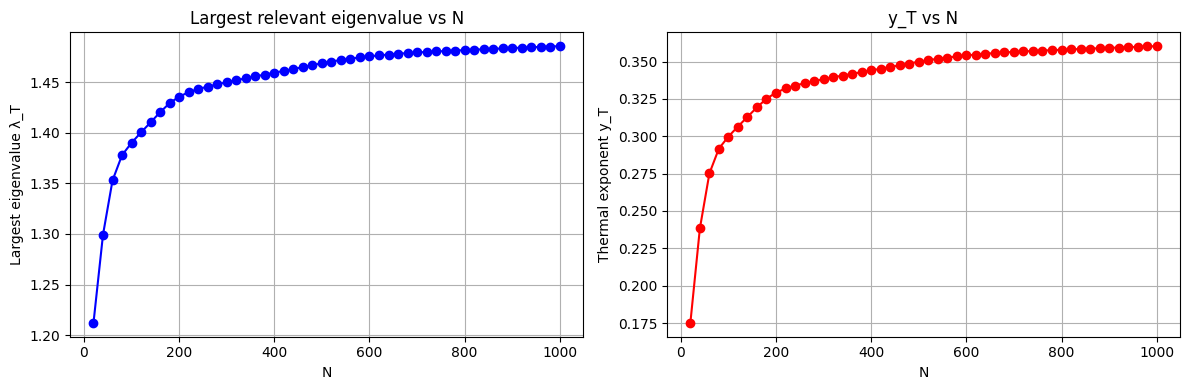

In [27]:
# ----- plots -----
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(Ns, lambda_Ts, 'b-o')
ax[0].set_xlabel("N")
ax[0].set_ylabel("Largest eigenvalue λ_T")
ax[0].set_title("Largest relevant eigenvalue vs N")
ax[0].grid()

ax[1].plot(Ns, yTs, 'r-o')
ax[1].set_xlabel("N")
ax[1].set_ylabel("Thermal exponent y_T")
ax[1].set_title("y_T vs N")
ax[1].grid()

plt.tight_layout()
plt.savefig("../figures/yT_stability.png")
plt.show()

# Magnetization

In [2]:
a = 1
tolerance = 1e-5

Jc = find_Jc(
    a=a,
    Jlow=1e-2, Jhigh=1e2,
    max_steps=6, max_dist_final=5,
    tol=tolerance,
    growth_threshold=1e4, decay_threshold=1e-4
)
print("Critical J =", Jc)

J0 = build_initial_guess(Jc, a=a, D=200)
J_star, info = newton_rg_lstsq(J0, verbose=True)
print("Fixed point J*:\n", J_star)
err = check_fixed_point(J_star, tol=tolerance)
print()
yH, alphaH = magnetic_exponent_yH(J_star, eps=1e-8, b=3.0)
print("dH'/dH at fixed point =", alphaH)
print("y_H =", yH)

Critical J = 0.12799049526453016
[lstsq] iter 0: D=200, D1=66, ||J'-J||=1.960e-02
[lstsq] iter 1: D=200, D1=66, ||J'-J||=1.367e-02
[lstsq] iter 2: D=200, D1=66, ||J'-J||=8.602e-03
[lstsq] iter 3: D=200, D1=66, ||J'-J||=5.268e-03
[lstsq] iter 4: D=200, D1=66, ||J'-J||=1.874e-03
[lstsq] iter 5: D=200, D1=66, ||J'-J||=3.904e-04
[lstsq] iter 6: D=200, D1=66, ||J'-J||=1.304e-04
[lstsq] iter 7: D=200, D1=66, ||J'-J||=5.472e-05
[lstsq] iter 8: D=200, D1=66, ||J'-J||=2.147e-05
[lstsq] iter 9: D=200, D1=66, ||J'-J||=7.297e-06
Fixed point J*:
 [0.         0.12242913 0.05533485 0.03232251 0.02482908 0.022188
 0.02103317 0.01699398 0.01350825 0.01072418 0.00987416 0.00938945
 0.0089723  0.00849432 0.00820056 0.00792457 0.00782142 0.00787141
 0.00788337 0.0072592  0.00662165 0.00606923 0.00566228 0.00525101
 0.00488706 0.00450457 0.00409968 0.0037425  0.00367203 0.00363021
 0.00357539 0.00350288 0.00344999 0.00338925 0.00333532 0.00329874
 0.00325412 0.00318257 0.00312    0.00305597 0.00302074 0.00

In [8]:
J = Jc+.001
M = magnetization(J, a, Jc, max_dist_final=5, max_steps=10)
print("M =", M)

M = 0.004578677633383047


Jc = 0.4005859375


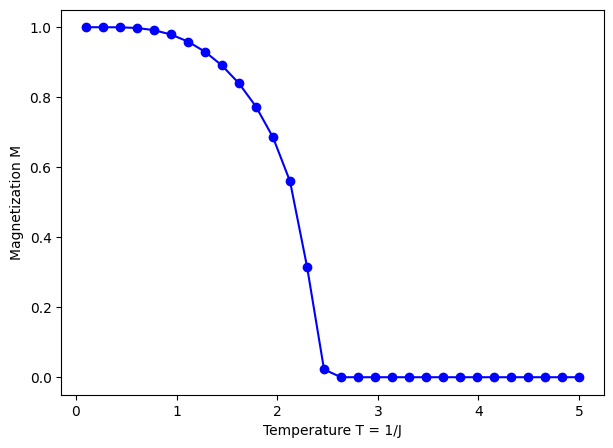

In [4]:
# Parameters
a = 1.5
Jc = find_Jc(
    a=a,
    Jlow=1e-2, Jhigh=1e2,
    max_steps=6, max_dist_final=5,
    tol=1e-5, growth_threshold=1e4, decay_threshold=1e-4
)
print(f"Jc = {Jc}")
T_values = np.linspace(0.1, 1.5 * Jc, 30)
J_values = 1.0 / T_values

M_values = [magnetization(J0, a, Jc) for J0 in J_values]

plt.figure(figsize=(7, 5))
plt.plot(T_values, M_values, 'b-o')
plt.xlabel("Temperature T = 1/J")
plt.ylabel("Magnetization M")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

# Critical exponents

In [ ]:
result = compute_exponents_over_a(
    a_min=1.2, a_max=2.0,
    num_points=10,
    D_init=100, N_matrix=100,
    d_dim=1.0, b=3.0
)

a = result["a"]
exps = [
    ("yT",     result["yT"]),
    ("yH",     result["yH"]),
    ("β",      result["beta"]),
    ("δ",      result["delta"]),
    ("η",      result["eta"]),
    ("ν",      result["nu"]),
    ("α",      result["alpha"]),
    ("γ",      result["gamma"]),
]

fig, axes = plt.subplots(4, 2, figsize=(7, 12))
axes = axes.flatten()

for i, (name, vals) in enumerate(exps):
    ax = axes[i]
    ax.plot(a, vals, marker="o")
    ax.set_title(name)
    ax.set_xlabel("a")
    ax.grid(True)
plt.tight_layout()
plt.show()